In [413]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [414]:
data = pd.read_csv("reduced_data.csv", sep=';')
data.head()

,body_1_old_x,body_1_old_y,body_2_old_x,body_2_old_y,body_1_x,body_1_y,body_2_x,body_2_y,body_1_new_x,body_1_new_y,body_2_new_x,body_2_new_y
0,4273.81,6064.76,4472.86,6406.81,4262.05,6049.94,4454.43,6393.19,4260.46,6047.10,4456.02,6396.03
1,4273.81,6064.76,4673.38,6061.94,4260.46,6047.10,4654.35,6049.19,4257.41,6047.08,4657.40,6049.21
2,4472.86,6406.81,4868.65,6407.84,4456.02,6396.03,4845.42,6394.39,4450.72,6396.05,4850.72,6394.37
3,4472.86,6406.81,4274.90,6753.24,4450.72,6396.05,4250.41,6741.61,4450.87,6395.80,4250.26,6741.86
4,4472.86,6406.81,4671.58,6755.01,4450.87,6395.80,4644.87,6738.17,4449.27,6392.98,4646.47,6740.99


In [415]:
data.isna().sum()

body_1_old_x    0
body_1_old_y    0
body_2_old_x    0
body_2_old_y    0
body_1_x        0
body_1_y        0
body_2_x        0
body_2_y        0
body_1_new_x    0
body_1_new_y    0
body_2_new_x    0
body_2_new_y    0
dtype: int64

In [416]:
import numpy as np

data = data.dropna()

data['distance'] = np.sqrt((data['body_1_x'] - data['body_2_x']) ** 2 + (data['body_1_y'] - data['body_2_y']) ** 2)

data.head()

,body_1_old_x,body_1_old_y,body_2_old_x,body_2_old_y,body_1_x,body_1_y,body_2_x,body_2_y,body_1_new_x,body_1_new_y,body_2_new_x,body_2_new_y,distance
0,4273.81,6064.76,4472.86,6406.81,4262.05,6049.94,4454.43,6393.19,4260.46,6047.10,4456.02,6396.03,393.485231
1,4273.81,6064.76,4673.38,6061.94,4260.46,6047.10,4654.35,6049.19,4257.41,6047.08,4657.40,6049.21,393.895545
2,4472.86,6406.81,4868.65,6407.84,4456.02,6396.03,4845.42,6394.39,4450.72,6396.05,4850.72,6394.37,389.403454
3,4472.86,6406.81,4274.90,6753.24,4450.72,6396.05,4250.41,6741.61,4450.87,6395.80,4250.26,6741.86,399.419341
4,4472.86,6406.81,4671.58,6755.01,4450.87,6395.80,4644.87,6738.17,4449.27,6392.98,4646.47,6740.99,393.513935


In [417]:
X = data[['body_1_old_x', 'body_1_old_y', 'body_2_old_x','body_2_old_y', 'body_1_x', 'body_1_y', 'body_2_x', 'body_2_y', 'distance']].values
y = data[['body_1_new_x', 'body_1_new_y', 'body_2_new_x', 'body_2_new_y']].values

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [419]:
train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_tensor, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_tensor, batch_size=64, shuffle=False)

In [420]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()

In [421]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [422]:
def evaluate_model():
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [423]:
test_loss = []

def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        test_loss.append(evaluate_model())
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

train_model(500)

Epoch 1/500, Loss: 19749.25
Epoch 2/500, Loss: 15971.51171875
Epoch 3/500, Loss: 8351.93359375
Epoch 4/500, Loss: 4777.34228515625
Epoch 5/500, Loss: 963.0390625
Epoch 6/500, Loss: 403.5743408203125
Epoch 7/500, Loss: 274.2590026855469
Epoch 8/500, Loss: 266.3040771484375
Epoch 9/500, Loss: 469.3532409667969
Epoch 10/500, Loss: 178.08827209472656
Epoch 11/500, Loss: 177.3800048828125
Epoch 12/500, Loss: 150.474853515625
Epoch 13/500, Loss: 96.42957305908203
Epoch 14/500, Loss: 103.33960723876953
Epoch 15/500, Loss: 137.74766540527344
Epoch 16/500, Loss: 155.21759033203125
Epoch 17/500, Loss: 83.12510681152344
Epoch 18/500, Loss: 169.3415985107422
Epoch 19/500, Loss: 63.40024185180664
Epoch 20/500, Loss: 74.76664733886719
Epoch 21/500, Loss: 112.77363586425781
Epoch 22/500, Loss: 53.58403396606445
Epoch 23/500, Loss: 140.5375213623047
Epoch 24/500, Loss: 191.61468505859375
Epoch 25/500, Loss: 67.38622283935547
Epoch 26/500, Loss: 50.993778228759766
Epoch 27/500, Loss: 77.22631072998047


In [424]:
print("Test Loss:", evaluate_model())

Test Loss: 10.997651813341223


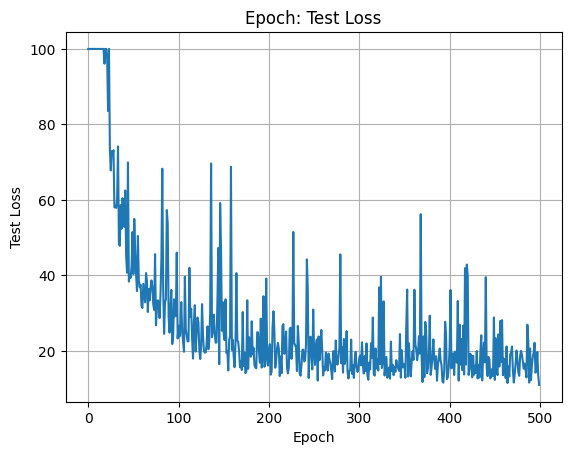

In [425]:
import matplotlib.pyplot as plt
import numpy as np

x_values = range(len(test_loss))
y_values = test_loss

clipped_y_values = np.clip(y_values, None, 100)

plt.plot(x_values, clipped_y_values)  
plt.title('Epoch: Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.grid(True)
plt.show()

In [426]:
def predict(p):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor([p], dtype=torch.float32)
        outputs = model(inputs)
        return outputs.numpy()

# 207.0	200.0	249.0	200.0	207.000	200.463	249.000	200.000	188.002	200.672	267.998	199.791
# 249.0	200.0	207.0	200.0	267.998	199.791	188.002	200.672	267.998	199.791	188.002	200.672
my_test = data.iloc[80].tolist()[:9]
my_res = predict(my_test)
my_res = my_res.tolist()[0]
my_res

[7838.94580078125, 7004.88916015625, 8007.11328125, 6749.203125]

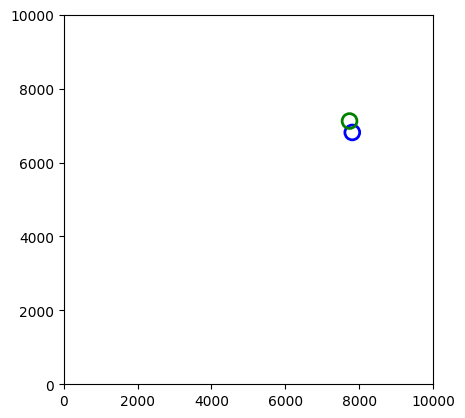

In [427]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Create a new figure
fig, ax = plt.subplots()

# Specify the dimensions of your plot area
ax.set_xlim((0, 10000))
ax.set_ylim((0, 10000))

# Add circles
circle1 = Circle((my_test[4], my_test[5]), 200, edgecolor='blue', facecolor='none', linewidth=2)
circle2 = Circle((my_test[6], my_test[7]), 200, edgecolor='green', facecolor='none', linewidth=2)

# Add the circles to the axes
ax.add_patch(circle1)
ax.add_patch(circle2)

# Optionally set aspect of the plot to be equal, so the circle isn't skewed
ax.set_aspect('equal')

# Display the plot
plt.show()

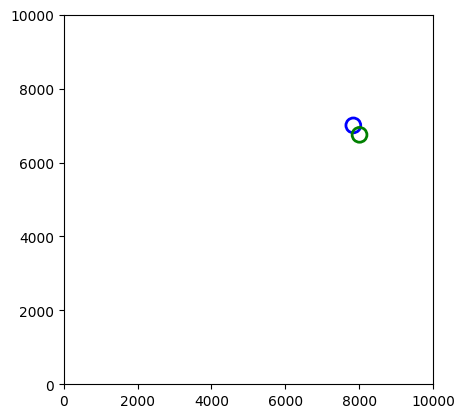

In [428]:
# Create a new figure
fig, ax = plt.subplots()

# Specify the dimensions of your plot area
ax.set_xlim((0, 10000))
ax.set_ylim((0, 10000))

# result
circle1 = Circle((my_res[0], my_res[1]), 200, edgecolor='blue', facecolor='none', linewidth=2)
circle2 = Circle((my_res[2], my_res[3]), 200, edgecolor='green', facecolor='none', linewidth=2)

# Add the circles to the axes
ax.add_patch(circle1)
ax.add_patch(circle2)

# Optionally set aspect of the plot to be equal, so the circle isn't skewed
ax.set_aspect('equal')

# Display the plot
plt.show()

In [429]:
traced_net = torch.jit.trace(model, torch.rand(1, 9))
torch.jit.save(traced_net, "../build/model.pt")

In [430]:
def half_data():
    # Load the data
    df = pd.read_csv('data.csv', sep=';')

    # Calculate the middle index
    half_index = len(df) // 10

    # Option A: Keep the first half
    df_first_half = df.tail(half_index)
    print(len(df_first_half))
    df_first_half.to_csv('reduced_data.csv', index=False, sep=';')